In [141]:
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()

In [4]:
# vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [122]:
g = torch.Generator().manual_seed(2147483647)

In [129]:
# dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [170]:
emb_size = 10
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((block_size*emb_size, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [171]:
sum(p.nelement() for p in parameters)

17697

In [172]:
for p in parameters:
    p.requires_grad = True

In [187]:
batch_size = 32
for i in tqdm(range(100000)):
    # Minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, block_size*emb_size) @ W1 + b1)
    logits = h @ W2 + b2

    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad


100%|██████████| 100000/100000 [00:18<00:00, 5311.55it/s]


In [188]:
# Validation (train set)
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size*emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss


tensor(2.0664, grad_fn=<NllLossBackward0>)

In [189]:
# Validation (validation set)
emb = C[X_val]
h = torch.tanh(emb.view(-1, block_size*emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.1336, grad_fn=<NllLossBackward0>)

In [194]:
# Sample from the model
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out[:-1]))

ten
ten
layveonna
ryra
alra
brie
emmiona
tollvin
kait
bales


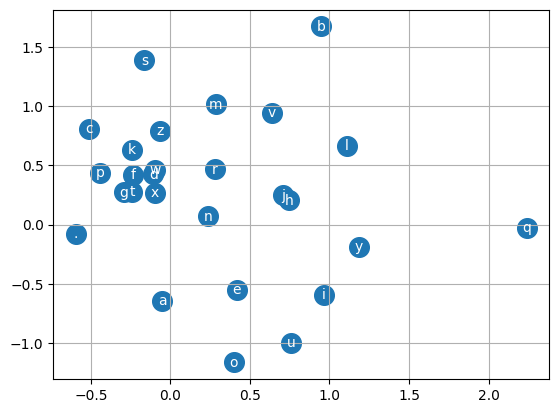

In [169]:
# Visualize embeddings (for ndims=2)
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid()